In [1]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression,RANSACRegressor,TheilSenRegressor
from statsmodels.robust.robust_linear_model import RLM
import statsmodels
import pandas as pd
from tqdm import tqdm
import random
from scipy import optimize
from sklearn.covariance import MinCovDet as MCD
import time
from sklearn.preprocessing import StandardScaler

In [2]:
def Add_Column(df, n):
    return np.column_stack([np.ones([df.shape[0], 1], dtype=np.int32), df])

In [3]:
# #МНК
# lr = LinearRegression(fit_intercept=False)
# lr.fit(df_norm, y_norm)
# mnk_coefs = lr.coef_
# #ransac
# ransac = RANSACRegressor(lr)
# ransac.fit(df_norm, y_norm)
# ransac_coefs = ransac.estimator_.coef_
# #Theil-Sen Regressor
# ths = TheilSenRegressor(fit_intercept=False)
# ths.fit(df_norm, y_norm)
# ths_coefs = ths.coef_
# # M-оценка
# m_est = RLM(y_norm, df_norm, M = statsmodels.robust.norms.TukeyBiweight()).fit()
# m_est_coefs = m_est.params
# #R-оценка
# beta = optimize.fmin_bfgs(R, [0, 0], args = (df_norm, y_norm), disp = 0)
# beta_0 = np.median(y_norm - np.sum(beta*df_norm[:,1:], axis = 1))
# r_est = np.concatenate((np.array([beta_0]), beta))
# #HBRR-оценка
# hbrr_beta = optimize.fmin_bfgs(HBR, [0, 0], args = (df_norm, y_nor, ransac_coefs), disp = 0)
# hbrr_beta_0 = np.median(y_norm - np.sum(hbrr_beta*df_norm[:,1:], axis = 1))
# hbrr_est = np.concatenate((np.array([hbrr_beta_0]), hbrr_beta))
# #MMR-оценка
# mmr_est = MM(df_norm, y_norm, ransac_coefs)

In [4]:
def MM(df, y, blms):
    n = df.shape[0]
    s = y - np.sum(blms * df, axis = 1)
    res_itog = np.abs(np.median(s) - s)
    MADN = np.median(np.abs(res_itog)) / 0.675
    const1 = 10
    const2 = 4.68
    var = s/(const1*MADN)
    w = np.minimum(3 - 3*np.power(var,2) + np.power(var,4), 1/np.power(var,2))
    sigma_1 = np.dot(w,np.power(s/const1,2))
    sigma_1 = np.sqrt(sigma_1 * 2/ df.shape[0])
    eps = 0.0001
    while(np.abs(sigma_1/MADN - 1) > eps):
        MADN = sigma_1
        sigma_1 = 0
        w = np.minimum(3 - 3*np.power(var,2) + np.power(var,4), 1/np.power(var,2))
        sigma_1 = np.dot(w,np.power(s/const1,2))
        sigma_1 = np.sqrt(sigma_1 * 2 / n)
    var2 = s/(const2*MADN)
    w = np.minimum(3 - 3*np.power(var2,2) + np.power(var2,4), 1/np.power(var2,2))
    W = np.diag(w)
    beta = blms
    beta_1 = np.dot(np.dot(np.dot(np.linalg.inv(np.dot(np.dot(df.T,W), df)), df.T), W), y)
    eps = 0.001
    while np.linalg.norm(beta_1-beta)/np.linalg.norm(beta) > eps:
        s = y - np.sum(beta_1 * df, axis = 1)
        var2 = s/(const2*sigma_1)
        w = np.minimum(3 - 3*np.power(var2,2) + np.power(var2,4), 1/np.power(var2,2))
        W = np.diag(w)
        beta = beta_1
        beta_1 = np.dot(np.dot(np.dot(np.linalg.inv(np.dot(np.dot(df.T,W), df)), df.T), W), y)
    return beta_1

In [5]:
def R(x, df, y):
    array = y - np.sum(x * df[:,1:], axis = 1)
    temp = array.argsort()
    ranks = np.empty_like(temp)
    ranks[temp] = np.arange(len(array))
    return np.dot(array, ranks/(df.shape[0]) - 0.5)

In [6]:
def HBR(x, df, y, lts):
    df = np.array(df)
    y = np.array(y)
    resid = y - np.sum(lts * df, axis = 1)
    MADN = 1.483*np.median(np.abs(resid - np.median(resid)))
    mcd = MCD()
    mcd.fit(df[:,1].reshape(-1,1))
    mahal =  mcd.mahalanobis(df[:,1].reshape(-1,1))
    b, c = 4, 4 
    resid = np.abs(resid / MADN)
    resid_new = y - np.sum(x * df[:,1:], axis = 1)
    resid_dif = np.abs(resid_new - resid_new.reshape(-1,1))
    resid_dif = np.tril(resid_dif, -1)
    mahal = b / mahal
    mahal[mahal > 1] = 1
    mahal = mahal / resid
    mahal = mahal.reshape(-1, 1) * mahal
    mahal = np.tril(mahal, -1)
    mahal = c * mahal
    mahal[mahal > 1] = 1
    ans = np.sum(mahal * resid_dif)
    return ans

# Звезды, датасет

In [7]:
stars = np.array(pd.read_csv('stars.csv'))
train = Add_Column(stars[:,0], stars.shape[0])
test = stars[:,1]
df_norm = train
y_norm = test

In [8]:
lr = LinearRegression(fit_intercept=False)
lr.fit(train, test)
mnk_coefs = lr.coef_

ransac = RANSACRegressor(lr, random_state=42)
ransac.fit(train, test)
ransac_coefs = ransac.estimator_.coef_

ths = TheilSenRegressor(fit_intercept=False, random_state = 42)
ths.fit(train, test)
ths_coefs = ths.coef_

m_est = RLM(test, train, M = statsmodels.robust.norms.TukeyBiweight()).fit()
m_est_coefs = m_est.params

mm_est = MM(train, test, ransac_coefs)

#R-оценка
beta = optimize.fmin_bfgs(R, 0, args = (train, test), disp = 0)
beta_0 = np.median(test - beta * train[:,1])
r_est = np.array([beta_0, beta])

#HBR-оценка
hbr_beta = optimize.fmin_bfgs(HBR, 0, args = (train, test, ransac_coefs), disp = 0)
hbr_est = np.array([np.median(test - hbr_beta * train[:,1]),hbr_beta])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


In [9]:
min_max = np.array([np.min(train[:,1]),np.max(train[:,1])])

In [10]:
lr.fit(train[np.where(train[:,1] > 3.6)[0]], test[np.where(train[:,1] > 3.6)[0]])
perfect = lr.coef_

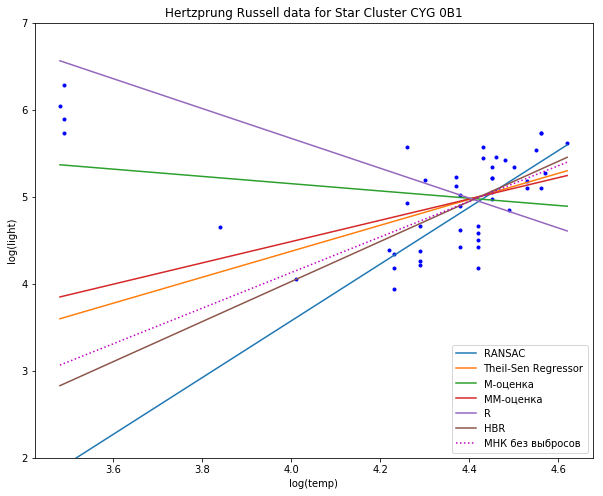

In [11]:
plt.figure(figsize = (10,8))
plt.plot(train[:,1],test, 'b.')
plt.plot(min_max, ransac_coefs[0] + ransac_coefs[1]*min_max, label = 'RANSAC')
plt.plot(min_max, ths_coefs[0] + ths_coefs[1]*min_max, label = 'Theil-Sen Regressor')
plt.plot(min_max, m_est_coefs[0] + m_est_coefs[1]*min_max, label = 'M-оценка')
plt.plot(min_max, mm_est[0] + mm_est[1]*min_max, label = 'ММ-оценка')
# plt.plot(min_max, lts_est[0] + lts_est[1]*min_max, label = 'LTS-оценка')
plt.plot(min_max, r_est[0] + r_est[1]*min_max, label = 'R')
plt.plot(min_max, hbr_est[0] + hbr_est[1]*min_max, label = 'HBR')
plt.plot(min_max, perfect[0] + perfect[1]*min_max, 'm:', label = 'МНК без выбросов')
plt.title('Hertzprung Russell data for Star Cluster CYG 0B1')
plt.legend()
plt.xlabel('log(temp)')
plt.ylabel('log(light)')
plt.ylim([2,7])
plt.show()

# Пенсионные фонды

In [12]:
train = np.array([10.4,15.6,16.2,17.9,37.8,46.9,52.4,52.9,71.0,73.9,76.3,77.0,131.2,151.7,206.1,314.7,470.8,1406.3])
test = np.array([272.2,212.9,120.7,163.6,226.1,622.9,1353.2,363.6,951.7,307.2,588.4,952.5,1157.3,
                 2105.6,3581.4,3404.7,4095.3,6802.7])
train = Add_Column(train, train.shape[0])

In [13]:
# lr = LinearRegression(fit_intercept=False)
lr.fit(train, test)
mnk_coefs = lr.coef_

# ransac = RANSACRegressor(lr, random_state=42)
ransac.fit(train, test)
ransac_coefs = ransac.estimator_.coef_

# ths = TheilSenRegressor(fit_intercept=False, random_state = 42)
ths.fit(train, test)
ths_coefs = ths.coef_

m_est = RLM(test, train, M = statsmodels.robust.norms.TukeyBiweight()).fit()
m_est_coefs = m_est.params

mm_est = MM(train, test, ransac_coefs)

#R-оценка
beta = optimize.fmin_bfgs(R, 0, args = (train, test), disp = 0)
beta_0 = np.median(test - beta * train[:,1])
r_est = np.array([beta_0, beta])

#HBR-оценка
hbr_beta = optimize.fmin_bfgs(HBR, 0, args = (train, test, ransac_coefs), disp = 0)
hbr_est = np.array([np.median(test - hbr_beta * train[:,1]),hbr_beta])

In [14]:
lr.fit(train[np.where(train[:,1] < 1000)[0]], test[np.where(train[:,1] < 1000)[0]])
perfect = lr.coef_

In [15]:
min_max = np.array([np.min(train[:,1]),np.max(train[:,1])])

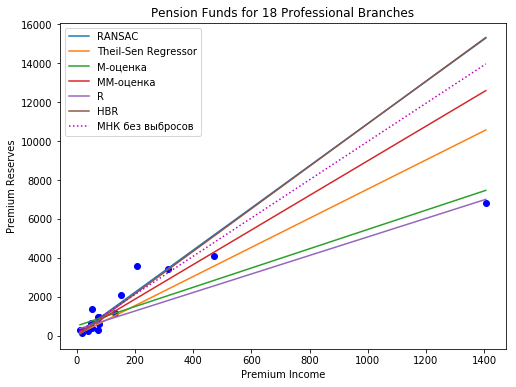

In [16]:
plt.figure(figsize = (8,6))
plt.plot(train[:,1],test, 'bo')
plt.plot(min_max, ransac_coefs[0] + ransac_coefs[1]*min_max, label = 'RANSAC')
plt.plot(min_max, ths_coefs[0] + ths_coefs[1]*min_max, label = 'Theil-Sen Regressor')
plt.plot(min_max, m_est_coefs[0] + m_est_coefs[1]*min_max, label = 'M-оценка')
plt.plot(min_max, mm_est[0] + mm_est[1]*min_max, label = 'ММ-оценка')
# plt.plot(min_max, lts_est[0] + lts_est[1]*min_max, label = 'LTS-оценка')
plt.plot(min_max, r_est[0] + r_est[1]*min_max, label = 'R')
plt.plot(min_max, hbr_est[0] + hbr_est[1]*min_max, label = 'HBR')
plt.plot(min_max, perfect[0] + perfect[1]*min_max, 'm:', label = 'МНК без выбросов')
plt.title('Pension Funds for 18 Professional Branches')
plt.legend()
plt.xlabel('Premium Income')
plt.ylabel('Premium Reserves')
plt.show()

# Aircraft

In [72]:
df_air = pd.read_csv('aircraft.csv').drop('Unnamed: 0', 1)
train = df_air[['X1', 'X2', 'X3', 'X4']]
test = df_air['Y']
train = Add_Column(train, train.shape[0])

In [73]:
lr = LinearRegression(fit_intercept=False)
lr.fit(train, test)
mnk_coefs = lr.coef_

ransac = RANSACRegressor(lr, random_state=42)
ransac.fit(train, test)
ransac_coefs = ransac.estimator_.coef_

ths = TheilSenRegressor(fit_intercept=False, random_state = 42)
ths.fit(train, test)
ths_coefs = ths.coef_

m_est = RLM(test, train, M = statsmodels.robust.norms.TukeyBiweight()).fit()
m_est_coefs = m_est.params

mm_est = MM(train, test, ransac_coefs)

#R-оценка
beta = optimize.fmin_bfgs(R, np.zeros(train.shape[1] - 1), args = (train, test), disp = 0)
beta_0 = np.median(test - np.sum(beta * train[:,1:], axis = 1))
r_est = np.concatenate((np.array([beta_0]), beta))

#HBR-оценка
hbrr_beta = optimize.fmin_bfgs(HBR, np.zeros(train.shape[1] - 1), args = (train, test, ransac_coefs), disp = 0)
hbrr_beta_0 = np.median(test - np.sum(hbrr_beta*train[:,1:], axis = 1))
hbrr_est = np.concatenate((np.array([hbrr_beta_0]), hbrr_beta))

In [74]:
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error, mean_absolute_error
from astropy.stats import median_absolute_deviation
from sklearn.preprocessing import StandardScaler

In [75]:
df_air = StandardScaler().fit_transform(df_air)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [77]:
train = df_air[:, :-1]
test = df_air[:, -1]

In [41]:
loo = LeaveOneOut()

In [42]:
mnk_mse = []
rs_mse = []
ths_mse = []
m_mse = []
r_mse = []
hbr_mse = []
mm_mse = []

for train_index, test_index in loo.split(train):
    X_train, X_test = train[train_index], train[test_index]
    y_train, y_test = test[train_index], test[test_index]
    lr.fit(X_train, y_train)
    mnk_coefs = lr.coef_
    mnk_mse.append(np.sum(mnk_coefs * X_test))
    
    ransac.fit(train, test)
    ransac_coefs = ransac.estimator_.coef_
    rs_mse.append(np.sum(ransac_coefs * X_test))
    
    ths.fit(train, test)
    ths_coefs = ths.coef_
    ths_mse.append(np.sum(ths_coefs * X_test))
    
    m_est = RLM(test, train, M = statsmodels.robust.norms.TukeyBiweight()).fit()
    m_est_coefs = np.array(m_est.params)
    m_mse.append(np.sum(m_est_coefs * X_test))
    
    mm_est = MM(train, test, ransac_coefs)
    mm_mse.append(np.sum(mm_est * X_test))
    
    beta = optimize.fmin_bfgs(R, np.zeros(train.shape[1] - 1), args = (train, test), disp = 0)
    beta_0 = np.median(test - np.sum(beta * train[:,1:], axis = 1))
    r_est = np.concatenate((np.array([beta_0]), beta))
    r_mse.append(np.sum(r_est * X_test))
    
    hbrr_beta = optimize.fmin_bfgs(HBR, np.zeros(train.shape[1] - 1), args = (train, test, ransac_coefs), disp = 0)
    hbrr_beta_0 = np.median(test - np.sum(hbrr_beta*train[:,1:], axis = 1))
    hbrr_est = np.concatenate((np.array([hbrr_beta_0]), hbrr_beta))
    hbr_mse.append(np.sum(hbrr_est * X_test))

In [43]:
print('leave-one out estimate for MSE:')
print('ols: {:0.2f}\nransac: {:0.2f}\nths-est: \
{:0.2f}\nm-est: {:0.2f}\nr-est: {:0.2f}\nhbr-est: {:0.2f}\nmm-est: {:0.2f}'.format(
                                                                        mean_squared_error(mnk_mse, test), 
                                                                        mean_squared_error(rs_mse, test), 
                                                                        mean_squared_error(ths_mse, test),
                                                                        mean_squared_error(m_mse, test), 
                                                                        mean_squared_error(r_mse, test), 
                                                                        mean_squared_error(hbr_mse, test), 
                                                                        mean_squared_error(mm_mse, test)))



leave-one out estimate for MSE:
ols: 0.25
ransac: 0.26
ths-est: 0.20
m-est: 0.19
r-est: 0.16
hbr-est: 0.17
mm-est: 0.17


In [44]:
print('leave-one out estimate for MAE:')
print('ols: {:0.2f}\nransac: {:0.2f}\nths-est: \
{:0.2f}\nm-est: {:0.2f}\nr-est: {:0.2f}\nhbr-est: {:0.2f}\nmm-est: {:0.2f}'.format(
                                                                        mean_absolute_error(mnk_mse, test), 
                                                                        mean_absolute_error(rs_mse, test), 
                                                                        mean_absolute_error(ths_mse, test),
                                                                        mean_absolute_error(m_mse, test), 
                                                                        mean_absolute_error(r_mse, test), 
                                                                        mean_absolute_error(hbr_mse, test), 
                                                                        mean_absolute_error(mm_mse, test)))



leave-one out estimate for MAE:
ols: 0.34
ransac: 0.29
ths-est: 0.27
m-est: 0.26
r-est: 0.27
hbr-est: 0.28
mm-est: 0.25


In [45]:
print('leave-one out estimate for MAD:')
print('ols: {:0.2f}\nransac: {:0.2f}\nths-est: \
{:0.2f}\nm-est: {:0.2f}\nr-est: {:0.2f}\nhbr-est: {:0.2f}\nmm-est: {:0.2f}'.format(
                                                                        median_absolute_deviation(mnk_mse - test), 
                                                                        median_absolute_deviation(rs_mse - test), 
                                                                        median_absolute_deviation(ths_mse - test),
                                                                        median_absolute_deviation(m_mse - test), 
                                                                        median_absolute_deviation(r_mse - test), 
                                                                        median_absolute_deviation(hbr_mse - test), 
                                                                        median_absolute_deviation(mm_mse - test)))

leave-one out estimate for MAD:
ols: 0.23
ransac: 0.16
ths-est: 0.14
m-est: 0.16
r-est: 0.17
hbr-est: 0.17
mm-est: 0.18


In [62]:
print('МНК: {}\nRANSAC: {}\nTHS-est: {}\nM-EST: {}\nMM: {}\nR-est: {}\nHBR-est: {}'.format(
    mnk_coefs, 
    ransac_coefs,
    ths_coefs,
    m_est_coefs,
    mm_est,
    r_est,
    hbrr_est
    
))

МНК: [-0.24452833  0.19840887  1.48531253 -0.90081367]
RANSAC: [-0.17848669  0.32925723  0.76906597 -0.41740245]
THS-est: [-0.20716385  0.31305045  0.92508066 -0.49697269]
M-EST: [-0.19581876  0.14786851  0.95869435 -0.51654319]
MM: [-0.16996556  0.14013163  0.99920362 -0.51033047]
R-est: [ 0.02047286  0.13359392  1.27825332 -0.55503434]
HBR-est: [ 0.03302379  0.12229004  1.22767036 -0.52387285]


# Alcohol

In [79]:
df_alco = pd.read_csv('alcohol.csv').drop('Unnamed: 0', 1)

In [80]:
df_alco = StandardScaler().fit_transform(df_alco)

In [81]:
train = df_alco[:, :-1]
test = df_alco[:, -1]

In [83]:
mnk_mse = []
rs_mse = []
ths_mse = []
m_mse = []
r_mse = []
hbr_mse = []
mm_mse = []

for train_index, test_index in loo.split(train):
    X_train, X_test = train[train_index], train[test_index]
    y_train, y_test = test[train_index], test[test_index]
    lr.fit(X_train, y_train)
    mnk_coefs = lr.coef_
    mnk_mse.append(np.sum(mnk_coefs * X_test))
    
    ransac.fit(train, test)
    ransac_coefs = ransac.estimator_.coef_
    rs_mse.append(np.sum(ransac_coefs * X_test))
    
    ths.fit(train, test)
    ths_coefs = ths.coef_
    ths_mse.append(np.sum(ths_coefs * X_test))
    
    m_est = RLM(test, train, M = statsmodels.robust.norms.TukeyBiweight()).fit()
    m_est_coefs = np.array(m_est.params)
    m_mse.append(np.sum(m_est_coefs * X_test))
    
    mm_est = MM(train, test, ransac_coefs)
    mm_mse.append(np.sum(mm_est * X_test))
    
    beta = optimize.fmin_bfgs(R, np.zeros(train.shape[1] - 1), args = (train, test), disp = 0)
    beta_0 = np.median(test - np.sum(beta * train[:,1:], axis = 1))
    r_est = np.concatenate((np.array([beta_0]), beta))
    r_mse.append(np.sum(r_est * X_test))
    
    hbrr_beta = optimize.fmin_bfgs(HBR, np.zeros(train.shape[1] - 1), args = (train, test, ransac_coefs), disp = 0)
    hbrr_beta_0 = np.median(test - np.sum(hbrr_beta*train[:,1:], axis = 1))
    hbrr_est = np.concatenate((np.array([hbrr_beta_0]), hbrr_beta))
    hbr_mse.append(np.sum(hbrr_est * X_test))

In [84]:
print('leave-one out estimate for MSE:')
print('ols: {:0.3f}\nransac: {:0.3f}\nths-est: \
{:0.3f}\nm-est: {:0.3f}\nr-est: {:0.3f}\nhbr-est: {:0.3f}\nmm-est: {:0.3f}'.format(
                                                                        mean_squared_error(mnk_mse, test), 
                                                                        mean_squared_error(rs_mse, test), 
                                                                        mean_squared_error(ths_mse, test),
                                                                        mean_squared_error(m_mse, test), 
                                                                        mean_squared_error(r_mse, test), 
                                                                        mean_squared_error(hbr_mse, test), 
                                                                        mean_squared_error(mm_mse, test)))



leave-one out estimate for MSE:
ols: 0.053
ransac: 0.017
ths-est: 0.037
m-est: 0.044
r-est: 0.026
hbr-est: 0.027
mm-est: 0.043


In [85]:
print('leave-one out estimate for MAE:')
print('ols: {:0.3f}\nransac: {:0.3f}\nths-est: \
{:0.3f}\nm-est: {:0.3f}\nr-est: {:0.3f}\nhbr-est: {:0.3f}\nmm-est: {:0.3f}'.format(
                                                                        mean_absolute_error(mnk_mse, test), 
                                                                        mean_absolute_error(rs_mse, test), 
                                                                        mean_absolute_error(ths_mse, test),
                                                                        mean_absolute_error(m_mse, test), 
                                                                        mean_absolute_error(r_mse, test), 
                                                                        mean_absolute_error(hbr_mse, test), 
                                                                        mean_absolute_error(mm_mse, test)))



leave-one out estimate for MAE:
ols: 0.139
ransac: 0.104
ths-est: 0.095
m-est: 0.094
r-est: 0.095
hbr-est: 0.095
mm-est: 0.094


In [86]:
print('leave-one out estimate for MAD:')
print('ols: {:0.3f}\nransac: {:0.3f}\nths-est: \
{:0.3f}\nm-est: {:0.3f}\nr-est: {:0.3f}\nhbr-est: {:0.3f}\nmm-est: {:0.3f}'.format(
                                                                        median_absolute_deviation(mnk_mse - test), 
                                                                        median_absolute_deviation(rs_mse - test), 
                                                                        median_absolute_deviation(ths_mse - test),
                                                                        median_absolute_deviation(m_mse - test), 
                                                                        median_absolute_deviation(r_mse - test), 
                                                                        median_absolute_deviation(hbr_mse - test), 
                                                                        median_absolute_deviation(mm_mse - test)))

leave-one out estimate for MAD:
ols: 0.106
ransac: 0.096
ths-est: 0.058
m-est: 0.038
r-est: 0.059
hbr-est: 0.057
mm-est: 0.038


In [87]:
print('МНК: {}\nRANSAC: {}\nTHS-est: {}\nM-EST: {}\nMM: {}\nR-est: {}\nHBR-est: {}'.format(
    mnk_coefs, 
    ransac_coefs,
    ths_coefs,
    m_est_coefs,
    mm_est,
    r_est,
    hbrr_est
))

МНК: [ -0.07177214  -0.74141121  -0.68571577  44.65133949  -2.21820728
 -41.92210804]
RANSAC: [ -0.10686949  -0.6940613   -0.68630406  43.35629812  -2.22170076
 -40.63901427]
THS-est: [  0.46777548  -0.90099956  -0.83318756   4.60956416 -10.55913089
   6.22969262]
M-EST: [ -0.66848488   1.08840923  -1.03913679  10.47985703 -12.00436952
   1.15533217]
MM: [ -0.8371842    1.31843915  -1.02346756   4.93357826 -11.77139709
   6.3862266 ]
R-est: [ -0.02414134  -0.34549658  -0.89235986  24.12562571  -8.01413844
 -15.85958553]
HBR-est: [ -0.02501875  -0.3366662   -0.89933853  23.60565266  -8.14012978
 -15.21551634]


# toxicity

In [100]:
df_toxicity = pd.read_csv('toxicity.csv').drop('Unnamed: 0', 1)
df_toxicity = StandardScaler().fit_transform(df_toxicity)

train = df_toxicity[:, 1:]
test = df_toxicity[:, 0]

In [101]:
mnk_mse = []
rs_mse = []
ths_mse = []
m_mse = []
r_mse = []
hbr_mse = []
mm_mse = []

for train_index, test_index in loo.split(train):
    X_train, X_test = train[train_index], train[test_index]
    y_train, y_test = test[train_index], test[test_index]
    lr.fit(X_train, y_train)
    mnk_coefs = lr.coef_
    mnk_mse.append(np.sum(mnk_coefs * X_test))
    
    ransac.fit(train, test)
    ransac_coefs = ransac.estimator_.coef_
    rs_mse.append(np.sum(ransac_coefs * X_test))
    
    ths.fit(train, test)
    ths_coefs = ths.coef_
    ths_mse.append(np.sum(ths_coefs * X_test))
    
    m_est = RLM(test, train, M = statsmodels.robust.norms.TukeyBiweight()).fit()
    m_est_coefs = np.array(m_est.params)
    m_mse.append(np.sum(m_est_coefs * X_test))
    
    mm_est = MM(train, test, ransac_coefs)
    mm_mse.append(np.sum(mm_est * X_test))
    
    beta = optimize.fmin_bfgs(R, np.zeros(train.shape[1] - 1), args = (train, test), disp = 0)
    beta_0 = np.median(test - np.sum(beta * train[:,1:], axis = 1))
    r_est = np.concatenate((np.array([beta_0]), beta))
    r_mse.append(np.sum(r_est * X_test))
    
    hbrr_beta = optimize.fmin_bfgs(HBR, np.zeros(train.shape[1] - 1), args = (train, test, ransac_coefs), disp = 0)
    hbrr_beta_0 = np.median(test - np.sum(hbrr_beta*train[:,1:], axis = 1))
    hbrr_est = np.concatenate((np.array([hbrr_beta_0]), hbrr_beta))
    hbr_mse.append(np.sum(hbrr_est * X_test))

In [102]:
print('leave-one out estimate for MSE:')
print('ols: {:0.2f}\nransac: {:0.2f}\nths-est: \
{:0.2f}\nm-est: {:0.2f}\nr-est: {:0.2f}\nhbr-est: {:0.2f}\nmm-est: {:0.2f}'.format(
                                                                        mean_squared_error(mnk_mse, test), 
                                                                        mean_squared_error(rs_mse, test), 
                                                                        mean_squared_error(ths_mse, test),
                                                                        mean_squared_error(m_mse, test), 
                                                                        mean_squared_error(r_mse, test), 
                                                                        mean_squared_error(hbr_mse, test), 
                                                                        mean_squared_error(mm_mse, test)))



leave-one out estimate for MSE:
ols: 0.33
ransac: 0.20
ths-est: 0.18
m-est: 0.18
r-est: 0.22
hbr-est: 0.22
mm-est: 0.21


In [103]:
print('leave-one out estimate for MAE:')
print('ols: {:0.2f}\nransac: {:0.2f}\nths-est: \
{:0.2f}\nm-est: {:0.2f}\nr-est: {:0.2f}\nhbr-est: {:0.2f}\nmm-est: {:0.2f}'.format(
                                                                        mean_absolute_error(mnk_mse, test), 
                                                                        mean_absolute_error(rs_mse, test), 
                                                                        mean_absolute_error(ths_mse, test),
                                                                        mean_absolute_error(m_mse, test), 
                                                                        mean_absolute_error(r_mse, test), 
                                                                        mean_absolute_error(hbr_mse, test), 
                                                                        mean_absolute_error(mm_mse, test)))



leave-one out estimate for MAE:
ols: 0.40
ransac: 0.29
ths-est: 0.29
m-est: 0.28
r-est: 0.33
hbr-est: 0.32
mm-est: 0.28


In [104]:
print('leave-one out estimate for MAD:')
print('ols: {:0.2f}\nransac: {:0.2f}\nths-est: \
{:0.2f}\nm-est: {:0.2f}\nr-est: {:0.2f}\nhbr-est: {:0.2f}\nmm-est: {:0.2f}'.format(
                                                                        median_absolute_deviation(mnk_mse - test), 
                                                                        median_absolute_deviation(rs_mse - test), 
                                                                        median_absolute_deviation(ths_mse - test),
                                                                        median_absolute_deviation(m_mse - test), 
                                                                        median_absolute_deviation(r_mse - test), 
                                                                        median_absolute_deviation(hbr_mse - test), 
                                                                        median_absolute_deviation(mm_mse - test)))

leave-one out estimate for MAD:
ols: 0.22
ransac: 0.18
ths-est: 0.16
m-est: 0.18
r-est: 0.18
hbr-est: 0.21
mm-est: 0.16


In [105]:
print('МНК: {}\nRANSAC: {}\nTHS-est: {}\nM-EST: {}\nMM: {}\nR-est: {}\nHBR-est: {}'.format(
    mnk_coefs, 
    ransac_coefs,
    ths_coefs,
    m_est_coefs,
    mm_est,
    r_est,
    hbrr_est
))

МНК: [ 1.26702043  0.27515766 -0.40563556  0.07391613  0.47294275 -1.17962828
  0.52949734 -0.3657697  -0.07493719]
RANSAC: [ 0.68082249 -0.18044244 -0.52296509 -0.18631616 -0.21330216  0.21858688
  0.48403196 -0.58436377  0.50919904]
THS-est: [ 0.75127056 -0.08330168 -0.43132813  0.0061306   0.02103787  0.12916763
 -0.04437528 -0.23026588  0.01735838]
M-EST: [ 0.83458564 -0.12245468 -0.52147307 -0.10565677 -0.15383343  0.11058923
  0.22061028 -0.36342172  0.32882744]
MM: [ 0.99549159 -0.09990082 -0.55367566 -0.08853307 -0.19358622  0.31368363
 -0.11328728 -0.17937811  0.07052905]
R-est: [-0.14095293 -0.35038964 -0.39985334 -0.13183966  0.02436642  0.58811888
  0.1700927  -0.54107858  0.60952413]
HBR-est: [-0.10301753 -0.39585647 -0.36514177 -0.3014664  -0.1372557   0.75222317
  0.31731555 -0.69421409  0.69512666]


# wagnerGrowth

In [94]:
df_vaso = pd.read_csv('wagnerGrowth.csv').drop(['Unnamed: 0', 'Region', 'Period'], 1)
df_vaso = StandardScaler().fit_transform(df_vaso)

train = df_vaso[:, :-1]
test = df_vaso[:, -1]

In [95]:
mnk_mse = []
rs_mse = []
ths_mse = []
m_mse = []
r_mse = []
hbr_mse = []
mm_mse = []

for train_index, test_index in loo.split(train):
    X_train, X_test = train[train_index], train[test_index]
    y_train, y_test = test[train_index], test[test_index]
    lr.fit(X_train, y_train)
    mnk_coefs = lr.coef_
    mnk_mse.append(np.sum(mnk_coefs * X_test))
    
    ransac.fit(train, test)
    ransac_coefs = ransac.estimator_.coef_
    rs_mse.append(np.sum(ransac_coefs * X_test))
    
    ths.fit(train, test)
    ths_coefs = ths.coef_
    ths_mse.append(np.sum(ths_coefs * X_test))
    
    m_est = RLM(test, train, M = statsmodels.robust.norms.TukeyBiweight()).fit()
    m_est_coefs = np.array(m_est.params)
    m_mse.append(np.sum(m_est_coefs * X_test))
    
    mm_est = MM(train, test, ransac_coefs)
    mm_mse.append(np.sum(mm_est * X_test))
    
    beta = optimize.fmin_bfgs(R, np.zeros(train.shape[1] - 1), args = (train, test), disp = 0)
    beta_0 = np.median(test - np.sum(beta * train[:,1:], axis = 1))
    r_est = np.concatenate((np.array([beta_0]), beta))
    r_mse.append(np.sum(r_est * X_test))
    
    hbrr_beta = optimize.fmin_bfgs(HBR, np.zeros(train.shape[1] - 1), args = (train, test, ransac_coefs), disp = 0)
    hbrr_beta_0 = np.median(test - np.sum(hbrr_beta*train[:,1:], axis = 1))
    hbrr_est = np.concatenate((np.array([hbrr_beta_0]), hbrr_beta))
    hbr_mse.append(np.sum(hbrr_est * X_test))

In [96]:
print('leave-one out estimate for MSE:')
print('ols: {:0.2f}\nransac: {:0.2f}\nths-est: \
{:0.2f}\nm-est: {:0.2f}\nr-est: {:0.2f}\nhbr-est: {:0.2f}\nmm-est: {:0.2f}'.format(
                                                                        mean_squared_error(mnk_mse, test), 
                                                                        mean_squared_error(rs_mse, test), 
                                                                        mean_squared_error(ths_mse, test),
                                                                        mean_squared_error(m_mse, test), 
                                                                        mean_squared_error(r_mse, test), 
                                                                        mean_squared_error(hbr_mse, test), 
                                                                        mean_squared_error(mm_mse, test)))



leave-one out estimate for MSE:
ols: 0.89
ransac: 0.89
ths-est: 0.80
m-est: 0.74
r-est: 0.77
hbr-est: 0.77
mm-est: 0.79


In [97]:
print('leave-one out estimate for MAE:')
print('ols: {:0.2f}\nransac: {:0.2f}\nths-est: \
{:0.2f}\nm-est: {:0.2f}\nr-est: {:0.2f}\nhbr-est: {:0.2f}\nmm-est: {:0.2f}'.format(
                                                                        mean_absolute_error(mnk_mse, test), 
                                                                        mean_absolute_error(rs_mse, test), 
                                                                        mean_absolute_error(ths_mse, test),
                                                                        mean_absolute_error(m_mse, test), 
                                                                        mean_absolute_error(r_mse, test), 
                                                                        mean_absolute_error(hbr_mse, test), 
                                                                        mean_absolute_error(mm_mse, test)))



leave-one out estimate for MAE:
ols: 0.73
ransac: 0.69
ths-est: 0.69
m-est: 0.67
r-est: 0.68
hbr-est: 0.68
mm-est: 0.66


In [98]:
print('leave-one out estimate for MAD:')
print('ols: {:0.2f}\nransac: {:0.2f}\nths-est: \
{:0.2f}\nm-est: {:0.2f}\nr-est: {:0.2f}\nhbr-est: {:0.2f}\nmm-est: {:0.2f}'.format(
                                                                        median_absolute_deviation(mnk_mse - test), 
                                                                        median_absolute_deviation(rs_mse - test), 
                                                                        median_absolute_deviation(ths_mse - test),
                                                                        median_absolute_deviation(m_mse - test), 
                                                                        median_absolute_deviation(r_mse - test), 
                                                                        median_absolute_deviation(hbr_mse - test), 
                                                                        median_absolute_deviation(mm_mse - test)))

leave-one out estimate for MAD:
ols: 0.55
ransac: 0.48
ths-est: 0.57
m-est: 0.52
r-est: 0.48
hbr-est: 0.48
mm-est: 0.43


In [99]:
print('МНК: {}\nRANSAC: {}\nTHS-est: {}\nM-EST: {}\nMM: {}\nR-est: {}\nHBR-est: {}'.format(
    mnk_coefs, 
    ransac_coefs,
    ths_coefs,
    m_est_coefs,
    mm_est,
    r_est,
    hbrr_est
))

МНК: [-0.2458133   0.12098531  0.08876425  0.31642709]
RANSAC: [-0.34025335  0.42478888 -0.15709205  0.49404302]
THS-est: [-0.49655549  0.13305208  0.04101008  0.2810387 ]
M-EST: [-0.30386028  0.13960105 -0.00360838  0.27877419]
MM: [-0.23919455  0.34630018  0.0070708   0.30971656]
R-est: [-0.04509467  0.24864887  0.11457138  0.33792788]
HBR-est: [-0.04307705  0.25529021  0.10679807  0.33887745]
